# Problem statement:
This Project is having 2 Problems to solve.
This dataset has 14 columns and 1517 rows. we have 2 task one is to analyze the dataset and predict the claim amount and second is to predict the insurance fraud by developing a supervised machine learning model.

Part 1)In part 1 of this project we will predict the claim amount of the insurance by developing a supervised regression model.

Part 2)In part 2 of this project we will predict the insurance fraud by developing a supervised Classification model.

In [38]:
!pip install fuzzywuzzy

In [39]:
# Import all the required liabrary
import numpy as np
import pandas as pd
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.feature_selection import RFE

In [40]:
#Load Train & Test Data Set
train = pd.read_excel('Data_Train.xlsx')
test = pd.read_excel('Data_Test.xlsx')
train.head()

,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES,COST
0,CASUAL DINING,9438,"Malwani, Goan, North Indian","11am – 4pm, 7:30pm – 11:30pm (Mon-Sun)",Thane,Dombivali East,3.6,49 votes,1200
1,"CASUAL DINING,BAR",13198,"Asian, Modern Indian, Japanese",6pm – 11pm (Mon-Sun),Chennai,Ramapuram,4.2,30 votes,1500
2,CASUAL DINING,10915,"North Indian, Chinese, Biryani, Hyderabadi","11am – 3:30pm, 7pm – 11pm (Mon-Sun)",Chennai,Saligramam,3.8,221 votes,800
3,QUICK BITES,6346,"Tibetan, Chinese",11:30am – 1am (Mon-Sun),Mumbai,Bandra West,4.1,24 votes,800
4,DESSERT PARLOR,15387,Desserts,11am – 1am (Mon-Sun),Mumbai,Lower Parel,3.8,165 votes,300


In [41]:
train["source"] = "train"
test["source"] = "test"

In [42]:
df = pd.concat([train,test])

# Analyzing the data:
Let’s start analyzing the data provided. We need to know the number of columns, rows, null objects, etc. So, let’s open the data and start counting the columns, get the row count, go through each row to find out any special characters or null values in it, find out the data type of each column provided.

In [43]:
#check the shape of data
df.shape

(16921, 10)

In [44]:
df.dtypes

TITLE             object
RESTAURANT_ID      int64
CUISINES          object
TIME              object
CITY              object
LOCALITY          object
RATING            object
VOTES             object
COST             float64
source            object
dtype: object

In [45]:
#Check if any missing value present in data
df.isnull().sum()

TITLE               0
RESTAURANT_ID       0
CUISINES            0
TIME                0
CITY              147
LOCALITY          128
RATING              4
VOTES            1606
COST             4231
source              0
dtype: int64

In [46]:
#Investigating the entire dataset first
df.duplicated().sum()

26

In [47]:
df= df.drop_duplicates()

In [48]:
# Data exploration for CITY
# CITY has 147 null values
#combining City and locality
df['Location']=df['CITY']+' '+df['LOCALITY']
df.drop(columns=['CITY','LOCALITY'])

,TITLE,RESTAURANT_ID,CUISINES,TIME,RATING,VOTES,COST,source,Location
0,CASUAL DINING,9438,"Malwani, Goan, North Indian","11am – 4pm, 7:30pm – 11:30pm (Mon-Sun)",3.6,49 votes,1200.0,train,Thane Dombivali East
1,"CASUAL DINING,BAR",13198,"Asian, Modern Indian, Japanese",6pm – 11pm (Mon-Sun),4.2,30 votes,1500.0,train,Chennai Ramapuram
2,CASUAL DINING,10915,"North Indian, Chinese, Biryani, Hyderabadi","11am – 3:30pm, 7pm – 11pm (Mon-Sun)",3.8,221 votes,800.0,train,Chennai Saligramam
3,QUICK BITES,6346,"Tibetan, Chinese",11:30am – 1am (Mon-Sun),4.1,24 votes,800.0,train,Mumbai Bandra West
4,DESSERT PARLOR,15387,Desserts,11am – 1am (Mon-Sun),3.8,165 votes,300.0,train,Mumbai Lower Parel
...,...,...,...,...,...,...,...,...,...
4226,CASUAL DINING,9057,"North Indian, Mughlai, Chinese",11:30am – 11:30pm (Mon-Sun),3.9,287 votes,NaN,test,New Delhi Punjabi Bagh
4227,None,1247,"Biryani, North Indian, Sandwich, Salad, Wraps",11am – 1am (Mon-Sun),4.3,469 votes,NaN,test,Bangalore HSR Layout
4228,QUICK BITES,8617,"Continental, North Indian",9:30am – 10:30pm (Mon-Sun),3.7,53 votes,NaN,test,Faridabad Sector 86
4229,QUICK BITES,6485,"Rolls, Beverages","11am – 11:30pm (Mon, Tue, Wed, Thu, Sat, Sun),...",-,NaN,NaN,test,Kochi Kochi


In [49]:
df.dropna(subset=['Location'],inplace=True)

In [50]:
from fuzzywuzzy import process
 
names_array=[]
def match_names(wrong_names,correct_names):
    for row in wrong_names:
        x=process.extractOne(row, correct_names)
        if x[1]<60:
            names_array.append('Others')
        else:
            names_array.append(x[0])
    return names_array
  
#Wrong country names dataset
correct_names=['Bangalore','Thane',
'Hyderabad','Andheri',
'Delhi', 'Kerala',
'Chennai', 'Bandra',
'Mumbai', 'Telangana',
'Kochi', 
'Noida', 
'Gurgaon', 'Ernakulam',
'Faridabad', 'Ghaziabad',
'Secunderabad' ]
name_match=match_names(df.Location,correct_names)    

print(len(names_array))
df['Location']=names_array

16747


In [51]:
cuisines_list=[]
for row in df['CUISINES']:
    cuisines_list.append(list(row.split(',')))

df['CUISINES']=cuisines_list

In [52]:
df['CUISINES'].isna().sum()

0

In [53]:
df_cuisines=df['CUISINES'].apply(lambda x: pd.Series(1, x))

In [54]:
title_list=[]
for row in df['TITLE']:
    title_list.append(list(row.split(',')))
df['TITLE']=title_list

In [55]:
df_title=df['TITLE'].apply(lambda x: pd.Series(1, x))

In [56]:
df_title.head()

,CASUAL DINING,BAR,QUICK BITES,DESSERT PARLOR,CAFÉ,MICROBREWERY,BEVERAGE SHOP,IRANI CAFE,BAKERY,None,...,FOOD TRUCK,MESS,KIOSK,CLUB,CONFECTIONERY,DHABA,MEAT SHOP,COCKTAIL BAR,PAAN SHOP,BHOJANALYA
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
df.head()

,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES,COST,source,Location
0,[CASUAL DINING],9438,"[Malwani, Goan, North Indian]","11am – 4pm, 7:30pm – 11:30pm (Mon-Sun)",Thane,Dombivali East,3.6,49 votes,1200.0,train,Thane
1,"[CASUAL DINING, BAR]",13198,"[Asian, Modern Indian, Japanese]",6pm – 11pm (Mon-Sun),Chennai,Ramapuram,4.2,30 votes,1500.0,train,Chennai
2,[CASUAL DINING],10915,"[North Indian, Chinese, Biryani, Hyderabadi]","11am – 3:30pm, 7pm – 11pm (Mon-Sun)",Chennai,Saligramam,3.8,221 votes,800.0,train,Chennai
3,[QUICK BITES],6346,"[Tibetan, Chinese]",11:30am – 1am (Mon-Sun),Mumbai,Bandra West,4.1,24 votes,800.0,train,Bandra
4,[DESSERT PARLOR],15387,[Desserts],11am – 1am (Mon-Sun),Mumbai,Lower Parel,3.8,165 votes,300.0,train,Mumbai


# Data Cleaning

In [58]:
df[df['RATING'].isna()]

,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES,COST,source,Location
204,[BAKERY],15062,[Bakery],Not Available,Kochi,Marine Drive,NaN,NaN,200.0,train,Kochi
421,[CAFÉ],14127,"[Cafe, Fast Food]",Not Available,Hyderabad,Banjara Hills,NaN,NaN,350.0,train,Hyderabad
2035,[QUICK BITES],2776,"[Kerala, Arabian]",Not Available,Kochi,Kakkanad,NaN,NaN,NaN,test,Kochi
2758,[None],11301,"[Chinese, North Indian, South Indian]",Not Available,Kochi,Tripunithura,NaN,NaN,NaN,test,Kochi


In [59]:
df["RATING"] = df.groupby("CITY").RATING.transform(lambda x : x.fillna(x.mode()[0]))

In [60]:
df['RATING']=df['RATING'].str.extract('(\d+)').astype(float)

In [61]:
df['VOTES'].isna().sum()

1579

In [62]:
df.VOTES.fillna('0',inplace=True)
df['VOTES']=df['VOTES'].str.extract('(\d+)').astype(float)

In [63]:
df.drop(columns='CITY',inplace=True)
df.drop(columns='LOCALITY',inplace=True)
df.drop(columns='CUISINES',inplace=True)

In [64]:
df_City=pd.get_dummies(df['Location'])
df.drop(columns='Location',inplace=True)
df_City.head()

,Andheri,Bandra,Bangalore,Chennai,Delhi,Ernakulam,Faridabad,Ghaziabad,Gurgaon,Hyderabad,Kerala,Kochi,Mumbai,Noida,Others,Secunderabad,Telangana,Thane
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [65]:
df = pd.concat([df,df_City,df_cuisines,df_title], axis=1)

In [66]:
df.drop(columns='TITLE',inplace=True)

In [67]:
df_column_category = df.select_dtypes(exclude=np.number).columns
df_column_category

Index(['TIME', 'source'], dtype='object')

In [68]:
df.drop(columns='TIME',inplace=True)

In [69]:
df.fillna(0,inplace=True)

In [70]:
train_final = df[df.source=="train"]
test_final = df[df.source=="test"]

# Model Selection for Part 1:
There are around 60+ predictive modeling algorithms that are available to choose from. We must have a good understanding of our data and the desired solution we are looking for, to narrow down our model selection. Here our goal is to predict the the average price by developing a supervised machine learning model and we want to identify a relation between our output (AveragePrice) and remaining independent features . This scenario is a classic example of Regression (Predict the average price).

We are provided with 1517 rows of the labeled dataset tagged with the output column “AveragePrice” to train our model. Whenever the dataset is labeled and output feature is known, we opt for the Supervised Learning Machine Learning technique. So, our use-case is a Supervised Learning plus Regression problem. Based on these criteria we can narrow down our choice of models to a few:

Linear Regression

DecisionTreeRegressor()

RandomForestRegressor()


# Identifying features:
Here we are dividing our data into a dependent feature that is object as y and independent features as x.

In [71]:
train_final.shape

(12552, 277)

In [72]:
train_final.drop(columns=["source"],inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [73]:
test_final.drop(columns=["source",'COST'],inplace=True)

# Splitting Data:
we split our data into a test set and train set using which helps to better train the model and test its performance. here we make a pair of the test set (x_test,y_test).

In [74]:
train_X = train_final.drop(columns=["COST",'RESTAURANT_ID'])

In [75]:
train_Y = train_final["COST"]

In [76]:
test_X = test_final.drop(columns=["RESTAURANT_ID"])

In [77]:
train_X.fillna(0,inplace=True)
train_X.isna().sum()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


RATING          0
VOTES           0
Andheri         0
Bandra          0
Bangalore       0
               ..
DHABA           0
MEAT SHOP       0
COCKTAIL BAR    0
PAAN SHOP       0
BHOJANALYA      0
Length: 274, dtype: int64

In [78]:
model = [LinearRegression(),DecisionTreeRegressor(),RandomForestRegressor()]

for m in model:
    m.fit(train_X, train_Y)
    m.score(train_X, train_Y)
    predm = m.predict(train_X)
    print('error')
    print('mae',mean_absolute_error(train_Y,predm))
    print('mse',mean_squared_error(train_Y,predm))
    print('rmse',np.sqrt(mean_squared_error(train_Y,predm)))
    print('score',r2_score(train_Y,predm))
    print('\n')

error
mae 188.81405146096145
mse 109770.49000021661
rmse 331.3162990258955
score 0.7224620542004816


error
mae 5.041196823977231
mse 1161.6792579632681
rmse 34.083416172139614
score 0.997062871132921


error
mae 70.9829946054969
mse 17677.175766431723
rmse 132.95554056312105
score 0.9553059565485879




# we can observe that ,Decision Tree Regressor algorithem worked very well.
Accuracy score of both algorithems are as given:-

Accuracy score of Linear Regression is 72%

Accuracy score of DecisionTreeRegressor() is 99%

Accuracy score of RandomForestRegressor() is 95%

Hence we can say that out all algorithems ,DecisionTreeRegressor() is best for this problem till now however we will use cross validation to select best model.

In [80]:
m =DecisionTreeRegressor()
m.fit(train_X, train_Y)
m.score(train_X, train_Y)
predm = m.predict(train_X)
print('error')
print('mae',mean_absolute_error(train_Y,predm))
print('mse',mean_squared_error(train_Y,predm))
print('rmse',np.sqrt(mean_squared_error(train_Y,predm)))
print('score',r2_score(train_Y,predm))
print('\n')

error
mae 5.041196823977231
mse 1161.6792579632681
rmse 34.083416172139614
score 0.997062871132921




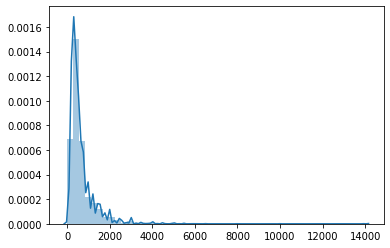

In [82]:
sns.distplot((train_Y,predm),bins=50)

# Save the model using Pickle

In [84]:
# Save the model using pickle
import pickle

filename = "pickleDTRfile.pkl"
pickle.dump(m, open(filename, 'wb'))


# Conclusion :
we achieved highest accuracy score of 99% by using DecisionTreeRegressor() which is good for any machine learning prediction model particularly for a linear regression problem. Finally! we successfully created a Regression Machine Learning prediction model using Python and its powerful libraries which predicts the Food cost of Restaurant.